In [22]:
#import module/library
import pandas as pd
import numpy as np
import pickle

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import layers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold

from Cleansing import clean

## EDA & Pre Processing

In [23]:
#read data training
trains = pd.read_csv("dataset/train_preprocess.tsv.txt", sep='\t', names=['Kalimat','Sentiment'])
trains.head()

,Kalimat,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [24]:
#check data volume
trains.shape

(11000, 2)

In [25]:
#check data null
trains.isna().sum()

Kalimat      0
Sentiment    0
dtype: int64

In [26]:
#check total data duplicated
trains.duplicated().sum()

67

In [27]:
#Remove data duplicated
traints = trains.drop_duplicates(inplace=False, ignore_index=True)

In [28]:
#check data voulume after remove duplicated
traints.shape

(10933, 2)

In [29]:
#check distribution label
traints.Sentiment.value_counts()

positive    6383
negative    3412
neutral     1138
Name: Sentiment, dtype: int64

In [30]:
#Clean data training
traints['Clean'] = traints.Kalimat.apply(clean)
traints.head()

C:\Users\BAV USER\AppData\Local\Temp\ipykernel_16900\628772995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traints['Clean'] = traints.Kalimat.apply(clean)


,Kalimat,Sentiment,Clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nya nya...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning bela...


In [31]:
neg = traints.loc[traints.Sentiment == 'negative'].Clean.tolist()
neu = traints.loc[traints.Sentiment == 'neutral'].Clean.tolist()
pos = traints.loc[traints.Sentiment == 'positive'].Clean.tolist()

neg_sntmnt = traints.loc[traints.Sentiment == 'negative'].Sentiment.tolist()
neu_sntmnt = traints.loc[traints.Sentiment == 'neutral'].Sentiment.tolist()
pos_sntmnt = traints.loc[traints.Sentiment == 'positive'].Sentiment.tolist()

In [32]:
total_data = pos + neu + neg
labels = pos_sntmnt + neu_sntmnt + neg_sntmnt

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


## Featute Extraction

In [33]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('asset/feature/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('asset/feature/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [34]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('asset/feature/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## Train Model

In [35]:
file = open("asset/feature/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("asset/feature/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [36]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 78, 100)           10000000  
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


875/875 [==============================] - 101s 112ms/step - loss: 0.5109 - accuracy: 0.7985 - val_loss: 0.3783 - val_accuracy: 0.8546
Epoch 2/10
875/875 [==============================] - 99s 113ms/step - loss: 0.2358 - accuracy: 0.9125 - val_loss: 0.4014 - val_accuracy: 0.8551
Epoch 2: early stopping


In [37]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 12ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       668
           1       0.81      0.65      0.72       231
           2       0.90      0.92      0.91      1288

    accuracy                           0.86      2187
   macro avg       0.83      0.79      0.81      2187
weighted avg       0.85      0.86      0.85      2187



In [38]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 13ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       668
           1       0.75      0.78      0.76       231
           2       0.93      0.87      0.90      1288

    accuracy                           0.85      2187
   macro avg       0.81      0.83      0.81      2187
weighted avg       0.85      0.85      0.85      2187



c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 15ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       668
           1       0.76      0.74      0.75       231
           2       0.91      0.93      0.92      1288

    accuracy                           0.86      2187
   macro avg       0.83      0.81      0.82      2187
weighted avg       0.86      0.86      0.86      2187



c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 14ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       668
           1       0.86      0.65      0.74       231
           2       0.90      0.92      0.91      1288

    accuracy                           0.86      2187
   macro avg       0.84      0.79      0.81      2187
weighted avg       0.86      0.86      0.86      2187



c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 14ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       668
           1       0.85      0.65      0.74       231
           2       0.90      0.93      0.91      1288

    accuracy                           0.86      2187
   macro avg       0.84      0.79      0.81      2187
weighted avg       0.86      0.86      0.86      2187



c:\Users\BAV USER\Python\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


69/69 [==============================] - 1s 14ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       668
           1       0.81      0.71      0.76       231
           2       0.88      0.95      0.92      1288

    accuracy                           0.86      2187
   macro avg       0.84      0.80      0.82      2187
weighted avg       0.86      0.86      0.86      2187




Rata-rata Accuracy:  0.8570644718792867


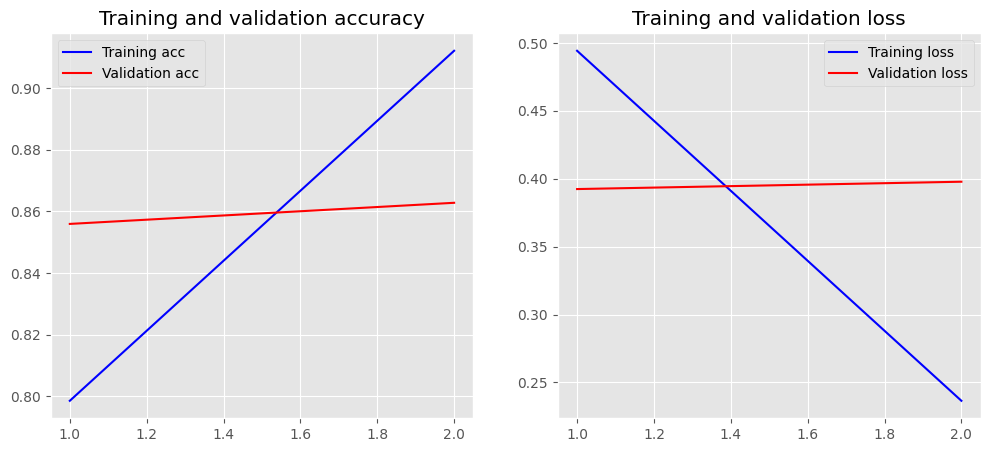

In [39]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [40]:
model.save('asset/model/model_lstm.h5')
print("Model has created!")

Model has created!


In [41]:
input_text = """
sabar dahulu"""

sentiment = ['negative', 'neutral', 'positive']

text = [clean(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('asset/model/model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 488ms/step
Text:  sabar
Sentiment:  positive
